# Importing modules
First, we will import the necessary libraries and read in the CSV data:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# from scripts.utils import add_seasonality
from sklearn.preprocessing import StandardScaler

In [161]:
# Read in the CSV data
df = pd.read_csv('/kaggle/input/stock-market-data/stock_market_data/sp500/csv/AAPL.csv')
df

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492
...,...,...,...,...,...,...,...
10585,06-12-2022,141.919998,147.070007,64727200,147.300003,142.910004,142.910004
10586,07-12-2022,140.000000,142.190002,69721100,143.369995,140.940002,140.940002
10587,08-12-2022,141.100006,142.360001,62128300,143.520004,142.649994,142.649994
10588,09-12-2022,140.899994,142.339996,76069500,145.570007,142.160004,142.160004


In [162]:
def create_sequences(data, t, y_step):
    X, y = [], []
    for i in range(0,len(data)-t-y_step-1):
        X.append(data.iloc[i:i+t, :]["Close"].values)
        y.append(data.iloc[i + t: i+t+y_step, :]["Close"].values)
    return np.array(X), np.array(y)

In [163]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(by="Date")

# Extract the year, month, and day as separate columns
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df.drop(columns=["Date", "Adjusted Close"], inplace=True)

In [164]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
train = df.iloc[:train_size, :]
val = df.iloc[train_size : train_size + val_size, :]
test = df.iloc[train_size + val_size :, :]

In [165]:
# Calculate the mean and standard deviation of each column in the training set
train_mean = train.mean()
train_std = train.std()

# Standardize the train, validation, and test sets using the calculated mean and std
train = (train - train_mean) / train_std
val = (val - train_mean) / train_std
test = (test - train_mean) / train_std

In [166]:
X_train, y_train = create_sequences(train, 22, 1)
X_val, y_val = create_sequences(val, 22, 1)
X_test, y_test = create_sequences(test, 22, 1)

In [167]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))


In [168]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8448, 22, 1), (8448, 1), (1035, 22, 1), (1035, 1), (1035, 22, 1), (1035, 1))

In [169]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

seed=42

def build_LSTM_regressor(input_shape, output_units):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    lstm = tfkl.LSTM(1024, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(256)(lstm)
    
    # Feature extractor
    classifier = tfkl.Dense(1024)(lstm)
    classifier = tfkl.LeakyReLU(alpha=0.2)(classifier)
    classifier = tfkl.Dense(512)(classifier)
    classifier = tfkl.LeakyReLU(alpha=0.2)(classifier)
    classifier = tfkl.Dense(256)(classifier)
    classifier = tfkl.LeakyReLU(alpha=0.2)(classifier)
    dropout = tfkl.Dropout(.3, seed=seed)(classifier)
    

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(dropout)  # No activation for regression

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='LSTM_regressor')

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    # Return the model
    return model

# Assuming input_shape is (t, number of features)
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = y_train.shape[1]  # Number of days to predict

# Build and compile the model
model = build_LSTM_regressor(input_shape, output_units)
model.summary()

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Model: "LSTM_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 22, 1)]           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 22, 1024)          4202496   
_________________________________________________________________
lstm_33 (LSTM)               (None, 256)               1311744   
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              263168    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 512)            

In [172]:
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (Mean Squared Error): {test_loss}")

33/33 [==============================] - 0s 7ms/step - loss: 98.8195 - mae: 7.8920
Test Loss (Mean Squared Error): [98.81951904296875, 7.891970634460449]


In [173]:
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (Mean Squared Error): {test_loss}")

33/33 [==============================] - 0s 8ms/step - loss: 98.8195 - mae: 7.8920
Test Loss (Mean Squared Error): [98.81951904296875, 7.891970634460449]


In [174]:
predictions = model.predict(X_test)
predictions

array([[ 8.537656],
       [ 8.563501],
       [ 8.690171],
       ...,
       [13.088428],
       [13.03868 ],
       [13.017094]], dtype=float32)

In [175]:
y_test

array([[ 9.21428067],
       [ 9.46826732],
       [ 9.62175574],
       ...,
       [25.58363641],
       [25.22366934],
       [25.53612631]])

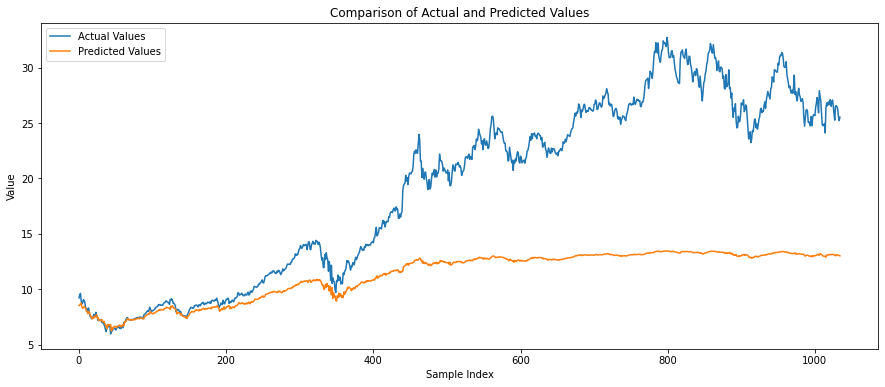

In [176]:
# Select a portion of data to plot, e.g., first 100 samples


# Plotting
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()
